In [1]:
# import libraries
import cv2
import numpy as np 
import matplotlib.pyplot as plt

We will break down the code that we had written for our autonomous vehicle in this notebook. This notebook serves to demonstrate the image processing that we had done for the path finding process of the robot.

In [2]:
# written function for robot
def find_yellow_lanes(bgr_img):
    hls_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HLS)

    lower_yellow = np.array([10, 30, 90])
    upper_yellow = np.array([40, 220, 255])

    yellow_filter = cv2.inRange(hls_img, lower_yellow, upper_yellow)
    yellow_filtered_img = cv2.bitwise_and(bgr_img, bgr_img, mask=yellow_filter)
    
    return yellow_filtered_img

In [3]:
# written function for robot
def find_n_largest_contours(bgr_img, n=2):
    # find contours
    img = bgr_img.copy()
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, h = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # sort contours by size
    area_array = []
    for i,c in enumerate(contours):
        area = cv2.contourArea(c)
        area_array.append(area)
    sorted_contours = sorted(zip(area_array, contours), key=lambda x:x[0], reverse=True)
    
    my_contours = []
    # top n size contours
    for i in range(n):
        try:
            my_contours.append(sorted_contours[i][1])
        except IndexError:
            break
    cv2.drawContours(img, my_contours, -1, (0,255,0))

    contour_centroids = []
    excepted = False
    # find center of top n size contours
    for c in my_contours:
        # center of the contour
        M = cv2.moments(c)
        try:
            # cX:row, cY:col, top_left: [0,0]
            cY = int(M["m10"] / M["m00"])
            cX = int(M["m01"] / M["m00"])
        except:
            excepted=True
        # draw the contour and center of the shape on the image
        if excepted:
            cX = int(img.shape[0]*0.7)
            cY = int(img.shape[1]*0.5)
        
        cv2.drawContours(img, [c], -1, (0, 255, 0), 2)
        cv2.circle(img, (cY, cX), 7, (255, 0, 0), -1)
        contour_centroids.append((cX, cY))
        
    # find second lowest positioned contour 
    sorted_centroids = sorted(contour_centroids, key=lambda tup: tup[0], reverse=True)
    
    if len(sorted_centroids)==0:
        cX = int(img.shape[0]*0.7)
        cY = int(img.shape[1]*0.5)
        cv2.circle(img, (cY, cX), 7, (255, 0, 0), -1)

    elif len(sorted_centroids)==1:
        cY, cX = sorted_centroids[0]
    else:
        cY, cX = sorted_centroids[1]
        
    return img, (cX, cY)

# Breaking down find_yellow_lanes()

Read the test image

In [4]:
bgr_img = cv2.imread('../test/testdata/img_19.png', 1)

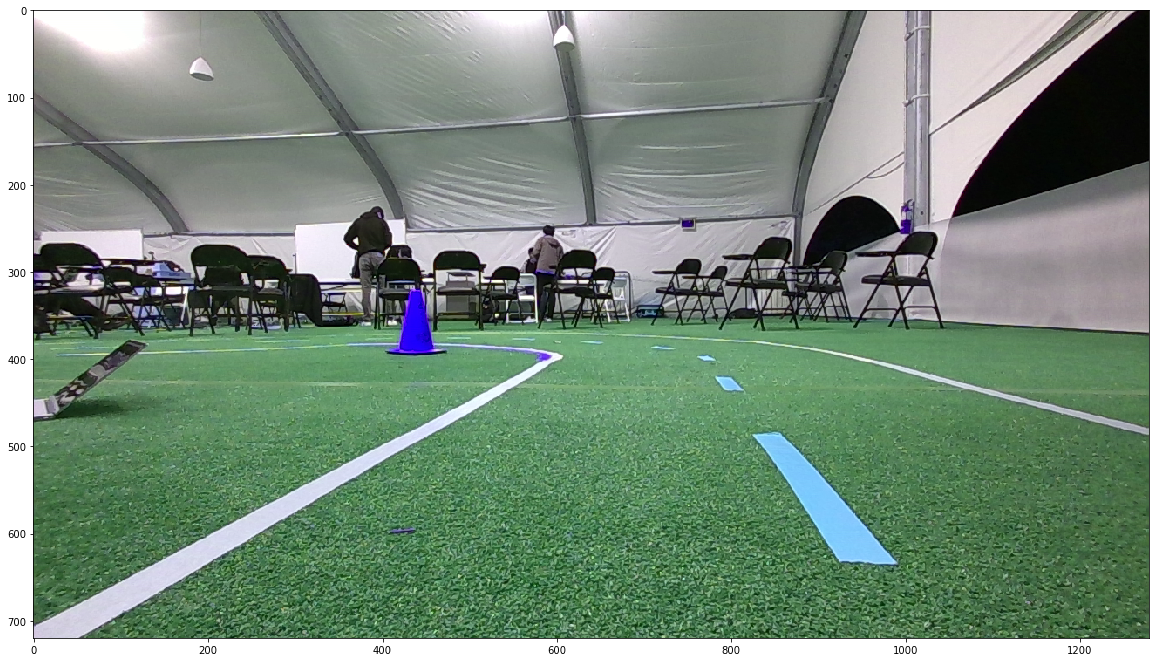

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(bgr_img)

The lanes were supposedly in yellow, while the cone was originally red. This is becasue cv2.imread reads images in BGR format, while the test data image is in RGB.

Convert BGR image to HLS format

In [6]:
hls_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HLS)

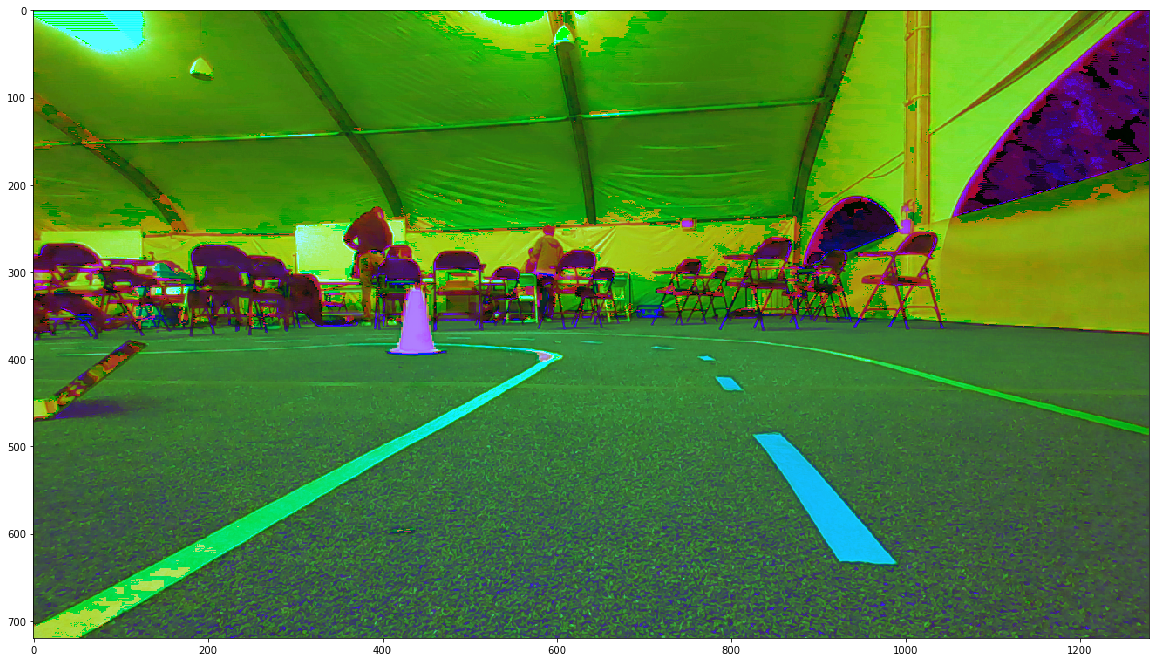

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(hls_img)

Detect only a certain range of color and filter out the other pixels, leaving only the lanes

In [8]:
#The colors are set because our track's lanes are yellow. In this case, blue.
lower_yellow = np.array([10, 30, 90])
upper_yellow = np.array([40, 220, 255])

yellow_filter = cv2.inRange(hls_img, lower_yellow, upper_yellow)
yellow_filtered_img = cv2.bitwise_and(bgr_img, bgr_img, mask=yellow_filter)

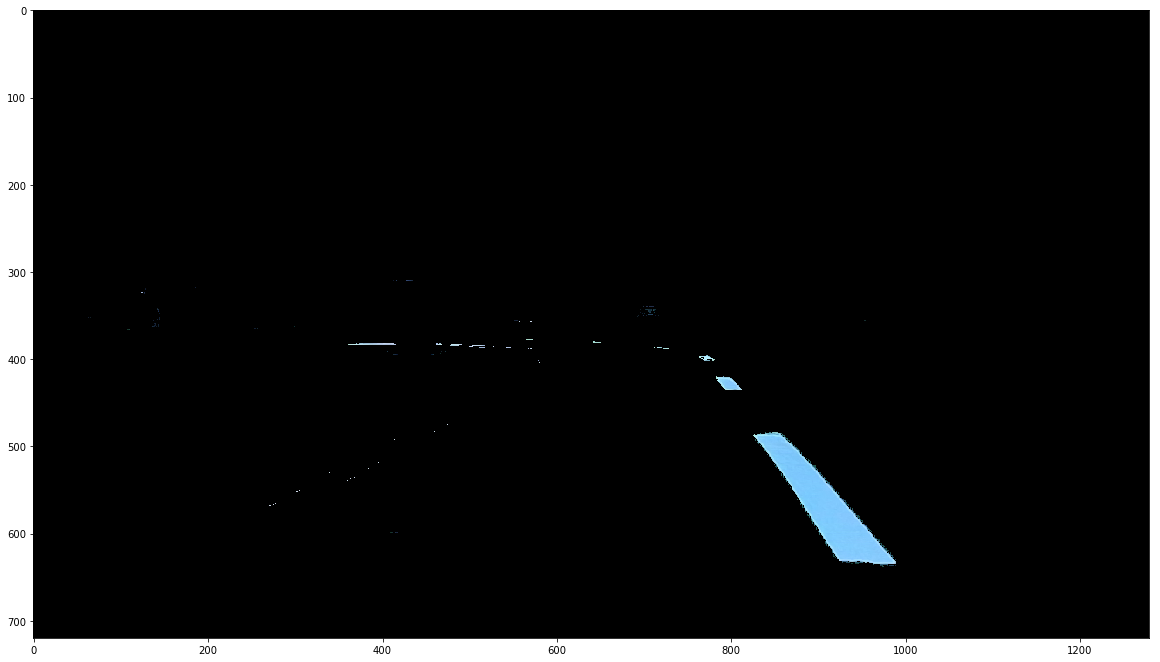

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(yellow_filtered_img)

After using this function, the lane is detected.

# Breaking down find_n_largest_contours()

We find the contours of the greyscaled filtered lane image.

In [10]:
# find contours
img = yellow_filtered_img.copy()
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contours, h = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

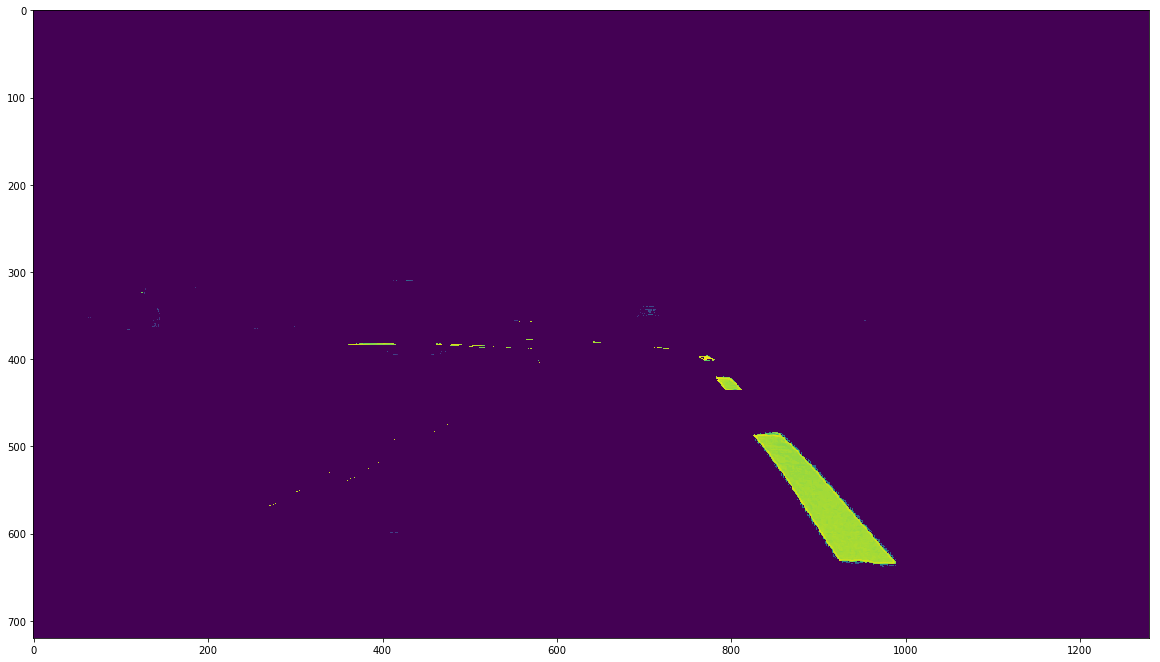

In [11]:
# greyscaled BGR image
plt.figure(figsize=(20,20))
plt.imshow(imgray)

In [12]:
# sort contours by size
area_array = []
for i,c in enumerate(contours):
    area = cv2.contourArea(c)
    area_array.append(area)
sorted_contours = sorted(zip(area_array, contours), key=lambda x:x[0], reverse=True)

In [13]:
sorted_contours[0]

(7354.5,
 array([[[840, 484]],
 
        [[840, 485]],
 
        [[839, 486]],
 
        ...,
 
        [[843, 485]],
 
        [[842, 485]],
 
        [[841, 485]]], dtype=int32))

In [14]:
my_contours = []
# top n size contours
for i in range(2):
    try:
        my_contours.append(sorted_contours[i][1])
    except IndexError:
        break
img_top_contours = cv2.drawContours(img, my_contours, -1, (0,255,0))

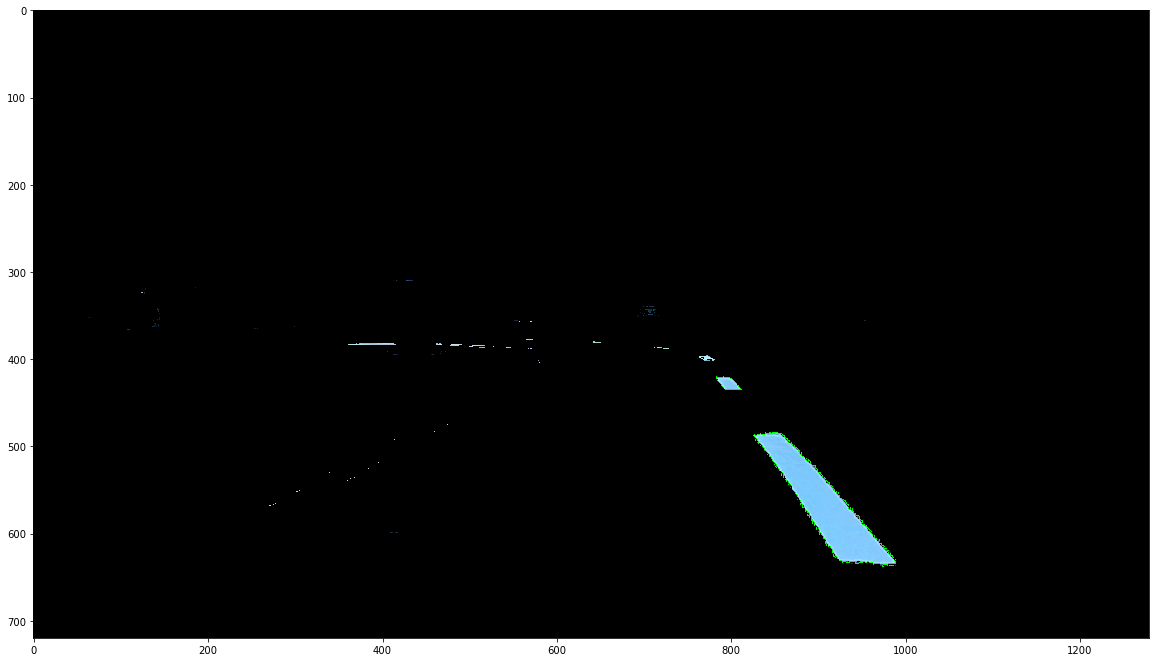

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(img_top_contours)

We will plot the centroids of the lanes on top of the image.

In [16]:
contour_centroids = []
excepted = False
# find center of top n size contours
for c in my_contours:
    # center of the contour
    M = cv2.moments(c)
    try:
        # cX:row, cY:col, top_left: [0,0]
        cY = int(M["m10"] / M["m00"])
        cX = int(M["m01"] / M["m00"])
    except:
        excepted=True
    # draw the contour and center of the shape on the image
    if excepted:
        cX = int(img.shape[0]*0.7)
        cY = int(img.shape[1]*0.5)
        
    img_center_contours = cv2.drawContours(img, [c], -1, (0, 255, 0), 2)
    cv2.circle(img, (cY, cX), 7, (255, 0, 0), -1)
    contour_centroids.append((cX, cY))

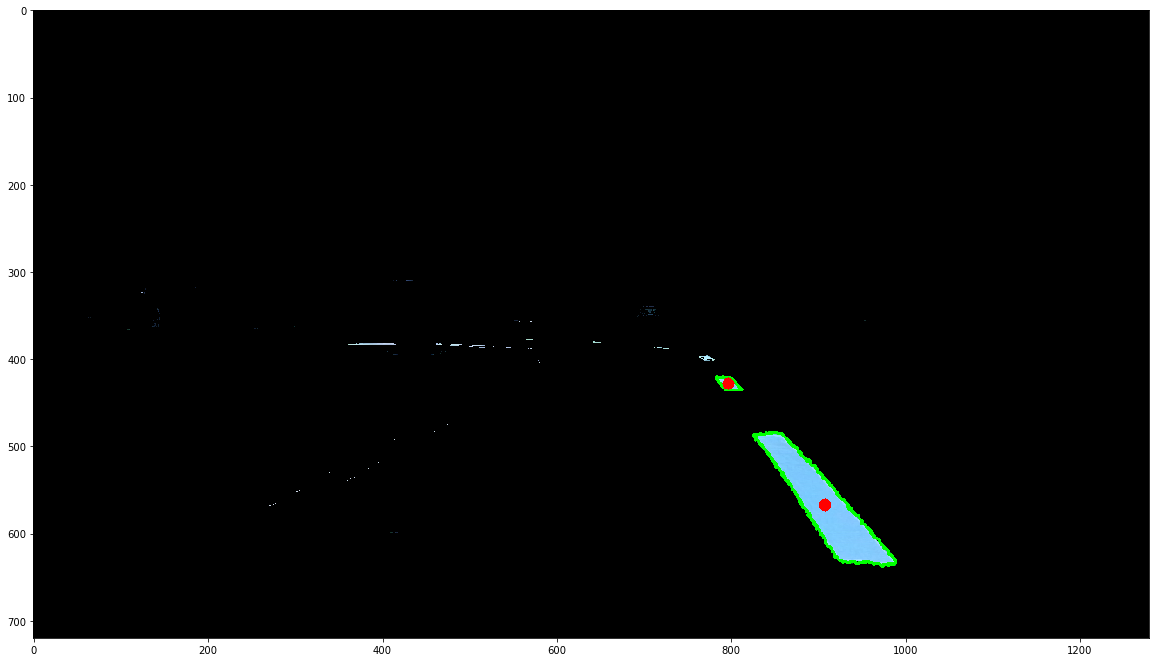

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(img_center_contours)

The red dots (centroids) are the targets that the autonomous vehicle will keep moving towards.

In [18]:
# find second lowest positioned contour 
sorted_centroids = sorted(contour_centroids, key=lambda tup: tup[0], reverse=True)
    
if len(sorted_centroids)==0:
    cX = int(img.shape[0]*0.7)
    cY = int(img.shape[1]*0.5)
    cv2.circle(img, (cY, cX), 7, (255, 0, 0), -1)

elif len(sorted_centroids)==1:
    cY, cX = sorted_centroids[0]
else:
    cY, cX = sorted_centroids[1]
    
# used in further programming

After finding the centroids on the detected lane, we will keep programming inside the robot using ROS to make it keep on following the found centroids physically. This is how the autonomous vehicle will start running on itself, following the track and the lane.